In [64]:
# ===============================================
# Enhanced Diabetes Analysis & Modeling Pipeline
# ===============================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from statsmodels.formula.api import logit
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

In [65]:
# -------- 1. Load dataset --------
df = pd.read_csv(r"C:\Users\asd\Desktop\Diabetes-Prediction\data\processed\cleaned.csv")

In [66]:
# -------- 2. Remove low variance columns --------
low_variance_cols = df.columns[df.var() < 1e-3]
df.drop(columns=low_variance_cols, inplace=True)


In [67]:
# -------- 3. Replace placeholders with NaN --------
placeholders = {
    'SkinThickness': 29.153419593345657,
    'Insulin': 155.5482233502538
}
for col, val in placeholders.items():
    df[col].replace(val, np.nan, inplace=True)


C:\Users\asd\AppData\Local\Temp\ipykernel_4200\2653786805.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace(val, np.nan, inplace=True)


In [68]:
# -------- 4. Impute missing values --------
imputer = SimpleImputer(strategy='median')
df[df.columns] = imputer.fit_transform(df)


In [69]:
# -------- 5. Domain-specific binary flags --------
df['High_BMI'] = (df['BMI'] >= 30).astype(int)
df['High_Glucose'] = (df['Glucose'] >= 126).astype(int)
df['Senior_Age'] = (df['Age'] >= 50).astype(int)
df['High_BP'] = (df['BloodPressure'] >= 80).astype(int)


In [70]:
# -------- 6. Polynomial & Interaction features --------
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_feats = poly.fit_transform(df[['Glucose', 'BMI', 'Age', 'Pregnancies']])
poly_cols = poly.get_feature_names_out(['Glucose', 'BMI', 'Age', 'Pregnancies'])
poly_df = pd.DataFrame(poly_feats, columns=poly_cols)
df = pd.concat([df, poly_df.iloc[:, 4:]], axis=1)  # skip original features


In [71]:
# -------- 7. Log-transform skewed features --------
for col in ['Insulin', 'DiabetesPedigreeFunction']:
    df[col] = np.log1p(df[col])


In [72]:
# -------- 8. Remove multicollinearity via VIF --------
X_vif = df.drop(columns=['Outcome'])
vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
high_vif = vif_df[vif_df["VIF"] > 10]["feature"]
df.drop(columns=high_vif, inplace=True)
print("Dropped high VIF features:", list(high_vif))


Dropped high VIF features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age', 'Glucose^2', 'Glucose BMI', 'Glucose Age', 'Glucose Pregnancies', 'BMI^2', 'BMI Age', 'BMI Pregnancies', 'Age^2', 'Age Pregnancies', 'Pregnancies^2']


In [73]:
# -------- 9. Scale features --------
scaler = StandardScaler()
features = df.drop(columns=['Outcome']).columns
df[features] = scaler.fit_transform(df[features])


In [74]:
# -------- 10. Statistical Analysis --------
print("\nDescriptive Statistics:\n", df.describe())


Descriptive Statistics:
        DiabetesPedigreeFunction     Outcome      High_BMI  High_Glucose  \
count              7.680000e+02  768.000000  7.680000e+02  7.680000e+02   
mean              -1.202742e-16    0.348958 -3.006854e-17 -8.095376e-18   
std                1.000652e+00    0.476951  1.000652e+00  1.000652e+00   
min               -1.462897e+00    0.000000 -1.301821e+00 -7.940864e-01   
25%               -7.419411e-01    0.000000 -1.301821e+00 -7.940864e-01   
50%               -2.454082e-01    0.000000  7.681550e-01 -7.940864e-01   
75%                6.097343e-01    1.000000  7.681550e-01  1.259309e+00   
max                4.356900e+00    1.000000  7.681550e-01  1.259309e+00   

         Senior_Age       High_BP  
count  7.680000e+02  7.680000e+02  
mean   3.353799e-17  1.063964e-16  
std    1.000652e+00  1.000652e+00  
min   -3.620430e-01 -6.034242e-01  
25%   -3.620430e-01 -6.034242e-01  
50%   -3.620430e-01 -6.034242e-01  
75%   -3.620430e-01  1.657209e+00  
max    2.7

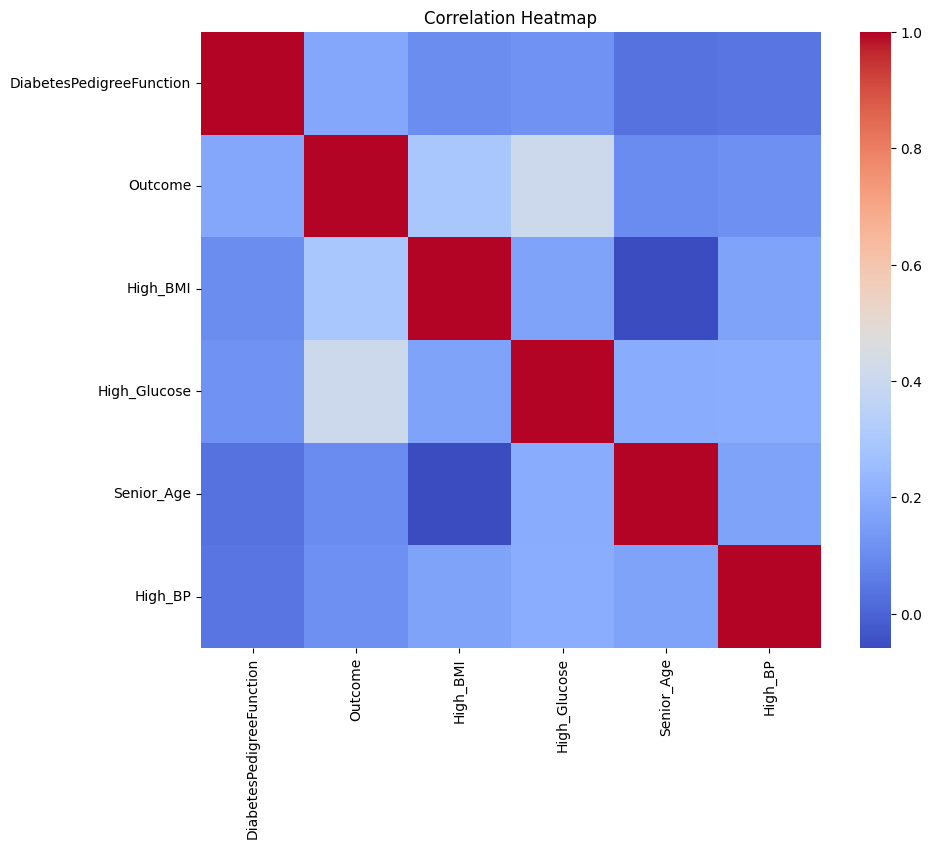

In [75]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [76]:
# t-test comparison between groups
out0, out1 = df[df['Outcome']==0], df[df['Outcome']==1]
comparison_results = []
for col in features:
    test = stats.ttest_ind(out0[col], out1[col])
    comparison_results.append((col, test.pvalue))
comparison_df = pd.DataFrame(comparison_results, columns=['Feature', 'p-value'])
# comparison_df.to_csv("group_comparison.csv", index=False)
print(comparison_df)


                    Feature       p-value
0  DiabetesPedigreeFunction  5.171702e-07
1                  High_BMI  4.613907e-17
2              High_Glucose  8.013517e-32
3                Senior_Age  4.692755e-03
4                   High_BP  1.550399e-03


In [77]:
# -------- 11. Modeling --------
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# Logistic Regression (L2)
lr = LogisticRegression(max_iter=1000, penalty='l2')
lr_scores = cross_val_score(lr, X, y, cv=5, scoring='roc_auc')
print("Logistic Regression ROC-AUC:", lr_scores.mean())

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print("Random Forest ROC-AUC:", rf_scores.mean())

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_scores = cross_val_score(xgb, X, y, cv=5, scoring='roc_auc')
print("XGBoost ROC-AUC:", xgb_scores.mean())


Logistic Regression ROC-AUC: 0.7806009783368275
Random Forest ROC-AUC: 0.708996855345912


c:\Users\asd\Desktop\Diabetes-Prediction\denv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:04:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\asd\Desktop\Diabetes-Prediction\denv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:04:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\asd\Desktop\Diabetes-Prediction\denv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:04:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\asd\Desktop\Diabetes-Prediction\denv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:04:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\

XGBoost ROC-AUC: 0.7223036338225018


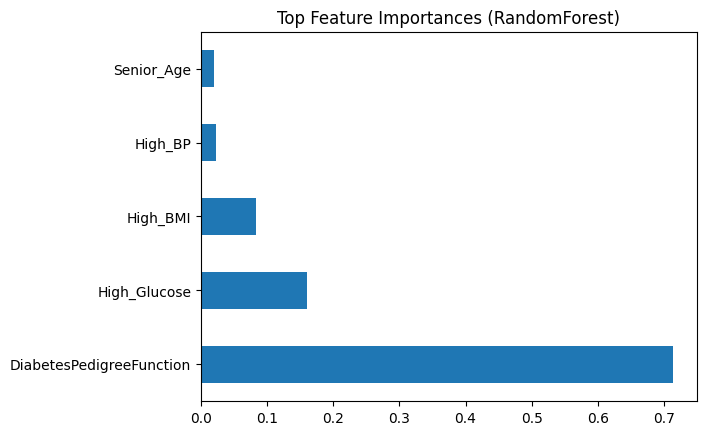

In [78]:
# # -------- 12. Feature Importance from RandomForest --------
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
# importances.to_csv("feature_importances.csv")
importances.head(15).plot(kind='barh')
plt.title("Top Feature Importances (RandomForest)")
plt.show()

# print("\nPipeline complete. Results saved: group_comparison.csv, feature_importances.csv")